In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Analyze by describing data

In [3]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [7]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Features

In [8]:
train_df.loc[(train_df["Cabin"].isna()),"Cabin"] = 0
train_df.loc[(train_df["Cabin"]!=0),"Cabin"] = 1
test_df.loc[(test_df["Cabin"].isna()),"Cabin"] = 0
test_df.loc[(test_df["Cabin"]!=0),"Cabin"] = 1

In [9]:
train_df = train_df.rename(columns = {"Cabin":"HasCabin"})
test_df = test_df.rename(columns = {"Cabin":"HasCabin"})

In [10]:
train_df[['HasCabin', 'Survived']].groupby(['HasCabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,HasCabin,Survived
1,1,0.666667
0,0,0.299854


In [11]:
comb_df = [train_df, test_df]

In [12]:
for dataset in comb_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [13]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,HasCabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,S


In [14]:
sex_class_mean_age = train_df.groupby(["Sex","Pclass"]).aggregate({"Age":"mean"}).reset_index()
for dataset in comb_df:
    for sex in [0,1]:
        for pclass in [1,2,3]:
            dataset.loc[(dataset.Sex == sex) & (dataset.Pclass == pclass) & (dataset.Age.isna()),'Age'] = \
            sex_class_mean_age.loc[(sex_class_mean_age.Sex == sex) & (sex_class_mean_age.Pclass == pclass),'Age'].iloc[0]
    dataset['Age'] = dataset['Age'].astype(int)
#train_df.loc[(train_df["Sex"] == True)&(train_df["Age"].isna()),"Age"] = round(sex_mean_age.male.iloc[0])
#train_df.loc[(train_df["Sex"] == False)&(train_df["Age"].isna()),"Age"] = round(sex_mean_age.female.iloc[0])

In [15]:
sex_class_mean_age

,Sex,Pclass,Age
0,0,1,41.281386
1,0,2,30.740707
2,0,3,26.507589
3,1,1,34.611765
4,1,2,28.722973
5,1,3,21.750000


In [16]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
train_df['Embarked'] = train_df['Embarked'].map({"S":0,"C":1,"Q":2})

In [17]:
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].map({"S":0,"C":1,"Q":2})


In [18]:
train_df = train_df.drop(["Ticket"],axis=1)
test_df = test_df.drop(["Ticket"],axis=1)

In [19]:
train_df = train_df.drop(["Name"],axis=1)
test_df = test_df.drop(["Name"],axis=1)

In [20]:
comb_df = [train_df,test_df]

In [21]:
train_df['Agecath'] = pd.cut(train_df['Age'], 5)
train_df[['Agecath', 'Survived']].groupby(['Agecath'], as_index=False).mean().sort_values(by='Agecath', ascending=True)

/tmp/ipykernel_44136/1073789734.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['Agecath', 'Survived']].groupby(['Agecath'], as_index=False).mean().sort_values(by='Agecath', ascending=True)


,Agecath,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [22]:
for dataset in comb_df:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked,Agecath
0,1,0,3,0,1,1,0,7.2500,0,0,"(16.0, 32.0]"
1,2,1,1,1,2,1,0,71.2833,1,1,"(32.0, 48.0]"
2,3,1,3,1,1,0,0,7.9250,0,0,"(16.0, 32.0]"
3,4,1,1,1,2,1,0,53.1000,1,0,"(32.0, 48.0]"
4,5,0,3,0,2,0,0,8.0500,0,0,"(32.0, 48.0]"


In [23]:
train_df = train_df.drop("Agecath",axis=1)
comb_df = [train_df, test_df]

In [24]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

/tmp/ipykernel_44136/2916669673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [25]:
train_df["Fare"] = train_df['Fare'].fillna(train_df['Fare'].dropna().median())
test_df["Fare"] = test_df['Fare'].fillna(test_df['Fare'].dropna().median())
comf_df = [train_df,test_df]
for dataset in comb_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
comb_df = [train_df, test_df]
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked
0,1,0,3,0,1,1,0,0,0,0
1,2,1,1,1,2,1,0,3,1,1
2,3,1,3,1,1,0,0,1,0,0
3,4,1,1,1,2,1,0,3,1,0
4,5,0,3,0,2,0,0,1,0,0


In [26]:
for dataset in comb_df:
    dataset["Alone"] = 1
    dataset.loc[dataset["SibSp"]+dataset["Parch"] > 0,'Alone'] = 0

In [27]:
train_df[['Alone', 'Survived']].groupby(['Alone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Alone,Survived
0,0,0.505650
1,1,0.303538


In [28]:
train_df = train_df.drop(["SibSp","Parch"],axis=1)
test_df = test_df.drop(["SibSp","Parch"],axis=1) 

In [29]:
comf_df = [train_df,test_df]

In [30]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Embarked,Alone
0,1,0,3,0,1,0,0,0,0
1,2,1,1,1,2,3,1,1,0
2,3,1,3,1,1,1,0,0,1
3,4,1,1,1,2,3,1,0,0
4,5,0,3,0,2,1,0,0,1


### Classification

In [31]:
X_t = train_df.drop("Survived",axis=1)
y_t = train_df.Survived

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_t,y_t,test_size = 0.25)

In [33]:
X_train.head()

,PassengerId,Pclass,Sex,Age,Fare,HasCabin,Embarked,Alone
584,585,3,0,1,1,0,1,1
259,260,2,1,3,2,0,0,0
751,752,3,0,0,1,1,0,0
466,467,2,0,1,0,0,0,1
633,634,1,0,2,0,0,0,1


### Logistic regression

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [35]:
logist = LogisticRegression(max_iter=400)
pipe_lr = make_pipeline(StandardScaler(),logist)
pipe_lr.fit(X_train,y_train)
y_pred_logist = pipe_lr.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred_logist))
print("accuracy Score on validation data:", accuracy_score(y_val, y_pred_logist))

F1 Score on validation data: 0.6826347305389222
accuracy Score on validation data: 0.7623318385650224


### SVM

In [36]:
svc = SVC(probability=True)
pipe_svc = make_pipeline(StandardScaler(),svc)
param_grid = {'svc__C':[1,10,100],'svc__gamma':[1,0.1,0.01,0.001], 'svc__kernel':['linear','rbf']}
search = GridSearchCV(pipe_svc, param_grid=param_grid, cv=3,verbose=True)
search.fit(X_train,y_train)
best_svc = search.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [37]:

y_pred_svc = best_svc.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred_svc))
print("accuracy Score on validation data:", accuracy_score(y_val, y_pred_svc))

F1 Score on validation data: 0.7272727272727273
accuracy Score on validation data: 0.8251121076233184


## Tree

In [38]:
tree = DecisionTreeClassifier()
param_grid={
    "criterion":["gini","entropy"],
    "max_depth":range(1,20)
}
search = GridSearchCV(tree, param_grid=param_grid, cv=5)

In [39]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)})

In [40]:
best_tree = search.best_estimator_

In [41]:

y_pred_tree = best_tree.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred_tree))
print("accuracy Score on validation data:", accuracy_score(y_val, y_pred_tree))

F1 Score on validation data: 0.7153284671532847
accuracy Score on validation data: 0.8251121076233184


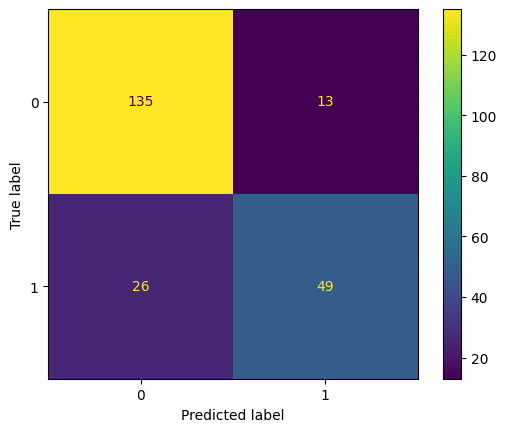

In [42]:
cm_tree = confusion_matrix(y_val,y_pred_tree)
ConfusionMatrixDisplay(cm_tree).plot()

## KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_param_grid={
    "n_neighbors":range(1,100)      
}
knn_search = GridSearchCV(knn, param_grid=knn_param_grid, cv=5)

In [45]:
knn_search.fit(X_train[["Age","Sex","Pclass","Fare","Alone","HasCabin","Embarked"]],y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 100)})

In [46]:
best_knn = knn_search.best_estimator_

In [47]:

y_val_pred = best_knn.predict(X_val[["Age","Sex","Pclass","Fare","Alone","HasCabin","Embarked"]])
print("F1 Score on validation data:", f1_score(y_val, y_val_pred))
print("accuracy Score on validation data:", accuracy_score(y_val, y_val_pred))

F1 Score on validation data: 0.6716417910447762
accuracy Score on validation data: 0.8026905829596412


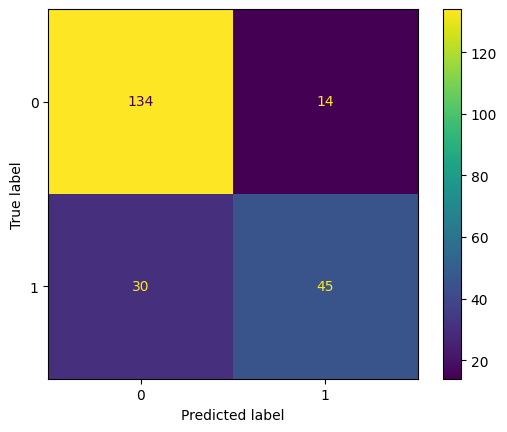

In [48]:
cm_knn = confusion_matrix(y_val,y_val_pred)
ConfusionMatrixDisplay(cm_knn).plot()

### Ensemble methods

### RandomForest

In [49]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import randint

In [50]:
param_dist = {'n_estimators': range(10,500),
              'max_depth': range(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier(class_weight='balanced')

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5)

In [ ]:
rand_search.fit(X_train, y_train)

In [ ]:
best_rf = rand_search.best_estimator_

In [ ]:
y_pred = best_rf.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred))
print("accuracy Score on validation data:", accuracy_score(y_val, y_pred))

In [ ]:
cm = confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay(cm).plot()

### Soft voting

In [ ]:
estimators = [
    ("lr",pipe_lr),
    ("svc",pipe_svc),
    ("tr",best_tree),
    ("knn",best_knn),
    ("rf",best_rf)
]
voting = VotingClassifier(estimators=estimators, voting='soft')
voting.fit(X_train, y_train)

In [ ]:
voting_y_pred = voting.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, voting_y_pred))
print("accuracy Score on validation data:", accuracy_score(y_val, voting_y_pred))

In [ ]:
cm = confusion_matrix(y_val,voting_y_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_val)

print("accuracy Score on validation data:", accuracy_score(y_val, y_pred))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)

print("accuracy Score on validation data:", accuracy_score(y_val, y_pred))

In [ ]:
Y_pred_res = best_rf.predict(test_df)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred_res
    })
submission.to_csv('./submission.csv', index=False)